In [1]:
import sys
sys.path.append("../")

In [6]:
import numpy as np
from rl.function_approx import FunctionApprox 
from typing import TypeVar
from dataclasses import dataclass, replace
from __future__ import annotations
from scipy.interpolate import BSpline, splrep


In [7]:
X = TypeVar('X')

@dataclass(frozen=True)
class UnivariateBSpline(FunctionApprox[X]):
    
    knots: np.ndarray
    coefficients: np.ndarray
    degree: int
    
    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        # can definitely optimize this further!!! O(n^2)
        y_values = []
        for x in x_values_seq:
            for i, (x0, x1) in enumerate(zip(self.knots[:-1], self.knots[1:])):
                if (x0 <= x) and (x <= x1):
                    break
            y = self._evaluate_x(x, self.coefficients[i])
            y_values.append(y)
        return np.array(y_values)
    
    def _evaluate_x(self, x, coefficients):
        return BSpline(self.knots, self.coefficients, self.degree)(x)
                
    def representational_gradient(self, x_value: X) -> UnivariateBSpline[X]:
        pass
    
    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> UnivariateBSpline[X]:
        spl = splrep(x, y)
        return UnivariateBSpline(knots=spl[0], coefficients=spl[1], degree=spl[2])
    
    def update(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> UnivariateBSpline[X]:
        new_bspline = self.solve(xy_vals_seq)
        return UnivariateBSpline( 
            knots=new_bspline.knots, 
            coefficients=new_bspline.coefficients, 
            degree=new_bspline.degree
        )
    
    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, UnivariateBSpline):
            return (
                np.all(np.abs(self.knots - other.knots) <= tolerance).item() 
                and 
                np.all(np.abs(self.coeffs - other.coeffs) <= tolerance).item()
            )

        return False

## Compare against Sklearn

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
from scipy.interpolate import UnivariateSpline
import seaborn as sns


In [9]:
x = np.linspace(0, 10, 10)
y = np.sin(x)

test = UnivariateBSpline(knots=None, coefficients=None, degree=None)
test = test.update(zip(x, y))

<AxesSubplot:>

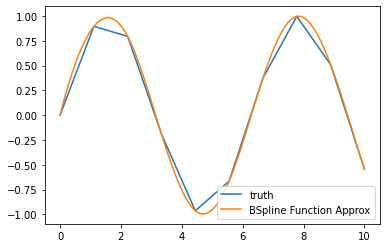

In [10]:
sns.lineplot(x=x, y=y, label='truth')
x_prime = np.linspace(0, 10, 100)

sns.lineplot(x=x_prime, y=test.evaluate(x_prime), label="BSpline Function Approx")